# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
import gc #garbage collector
import os #esta libreria permite trabajar con funciones del sistema operativo 
import statsmodels


# from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings 
warnings.filterwarnings('ignore')

In [3]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')

In [4]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [5]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [6]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [7]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [8]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [9]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [10]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2016, 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [11]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017, data_2016])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset_efectivo = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset_efectivo.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset_efectivo.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [12]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_efectivo['fecha2'] = pd.to_datetime(dataset_efectivo.fecha) + pd.to_timedelta(dataset_efectivo.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_efectivo.drop(columns=['fecha','hora_fin'], inplace = True)

dataset_efectivo.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [13]:
#Corregimos el nombre de fecha2 a fecha
dataset_efectivo.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset_efectivo.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [14]:
#Reordenamos el dataset por fecha
dataset_efectivo.sort_values('fecha', inplace = True)
dataset_efectivo.reset_index(drop=True, inplace = True)
dataset_efectivo

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Viernes     Centro       Liviano              14 2016-01-01 00:00:00
1       Viernes     Centro        Pesado               3 2016-01-01 00:00:00
2       Viernes  Provincia       Liviano              66 2016-01-01 00:00:00
3       Viernes  Provincia        Pesado               1 2016-01-01 00:00:00
4       Viernes  Provincia        Pesado               4 2016-01-01 00:00:00
...         ...        ...           ...             ...                 ...
346561   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
346562   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
346563   Martes     Centro       Liviano             580 2019-12-31 22:00:00
346564   Martes     Centro       Liviano             214 2019-12-31 23:00:00
346565   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[346566 rows x 5 columns]

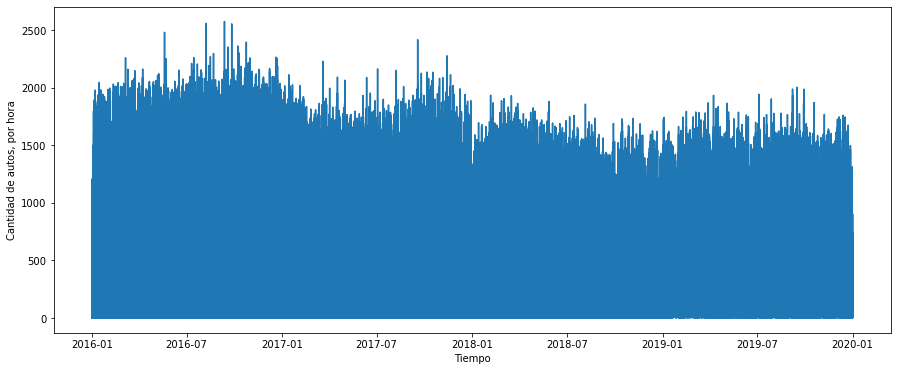

In [15]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset_efectivo.fecha, dataset_efectivo.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [16]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_efectivo = dataset_efectivo.resample('D', on = 'fecha').sum()
print(diario_efectivo.shape)
diario_efectivo.head()

(1461, 1)


cantidad_pasos
fecha                     
2016-01-01           25602
2016-01-02           36136
2016-01-03           37225
2016-01-04           50312
2016-01-05           49907

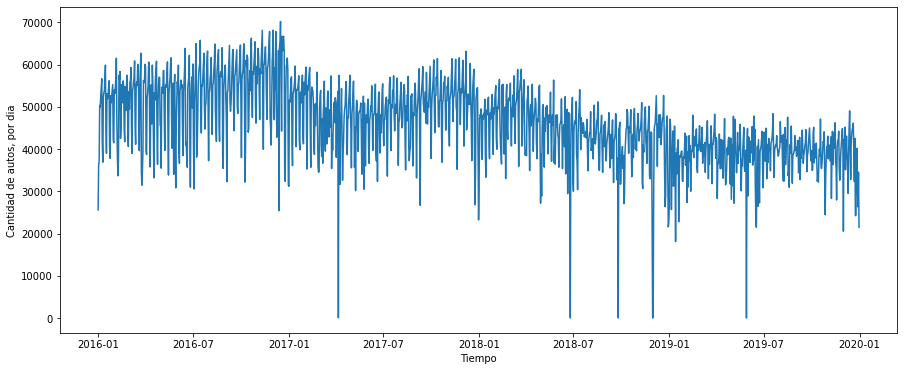

In [17]:
#Graficamos y visualizamos la cantidad de pasos por dia
plt.figure(figsize = (15,6))
plt.plot(diario_efectivo.index, diario_efectivo.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

## ELIMINACION DE OUTLIERS

***Elimino los outliers que observo por debajo de 10000 pasos diarios***

In [18]:
diario_efectivo.cantidad_pasos[diario_efectivo.cantidad_pasos < 10000] = np.nan
diario_efectivo

cantidad_pasos
fecha                     
2016-01-01         25602.0
2016-01-02         36136.0
2016-01-03         37225.0
2016-01-04         50312.0
2016-01-05         49907.0
...                    ...
2019-12-27         40182.0
2019-12-28         30681.0
2019-12-29         26259.0
2019-12-30         34523.0
2019-12-31         21447.0

[1461 rows x 1 columns]

In [19]:
#Ahora vemos si los reemplazo por Nan
print(diario_efectivo.isna().sum())
diario_efectivo = diario_efectivo.interpolate() #mira el valor anterior y el valor siguiente y hace un promedio, reemplazando el valor nan
print(diario_efectivo.isna().sum())

cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


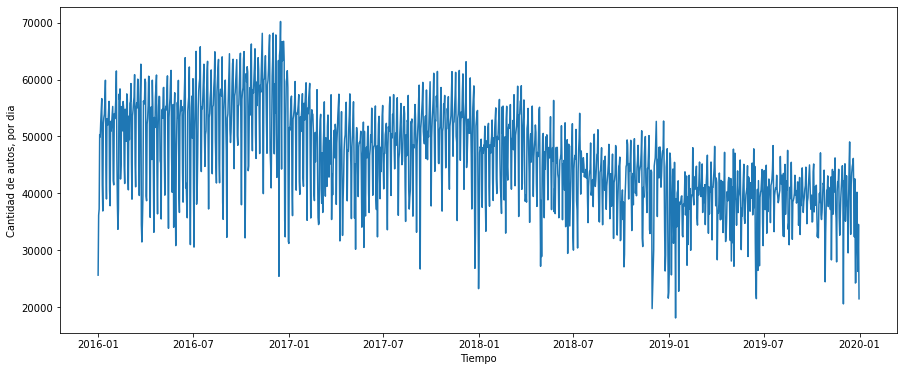

In [20]:
#Graficamos y visualizamos la cantidad de pasos por dia sin los outliers
plt.figure(figsize = (15,6))
plt.plot(diario_efectivo.index, diario_efectivo.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

**Media movil**

Realizo el *rolling window*, proceso por el cual se toma una ventana trasladable a lo largo de una serie de tiempo y hacer alguna operación en esa misma. 

Vamos a operar sobre la serie con una ventana de 365 dias

In [21]:
ventana = int(365)
cantidad_pasos_tendencia = diario_efectivo.cantidad_pasos.rolling(window=ventana, center = True).mean()
print(cantidad_pasos_tendencia.shape)

(1461,)


In [22]:
cantidad_pasos_tendencia.head()

fecha
2016-01-01   NaN
2016-01-02   NaN
2016-01-03   NaN
2016-01-04   NaN
2016-01-05   NaN
Freq: D, Name: cantidad_pasos, dtype: float64

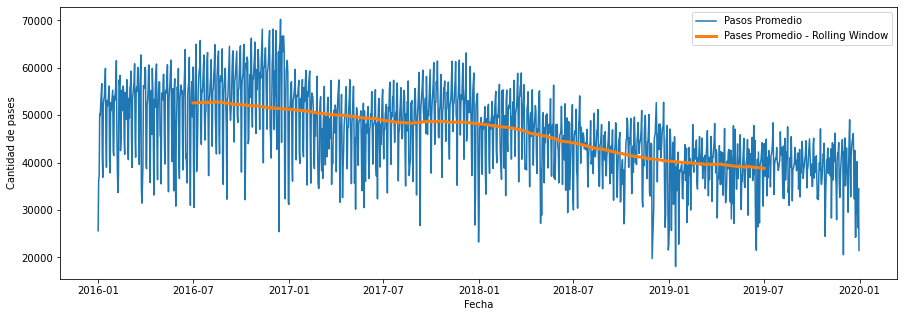

In [23]:
#Grafico los datos con los pases promedios de la ventana establecida
plt.figure(figsize = (15,5))
plt.plot(diario_efectivo.index, diario_efectivo.cantidad_pasos, label = 'Pasos Promedio')
plt.plot(cantidad_pasos_tendencia, lw = 3, label = 'Pases Promedio - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pases')
plt.legend()
plt.show()

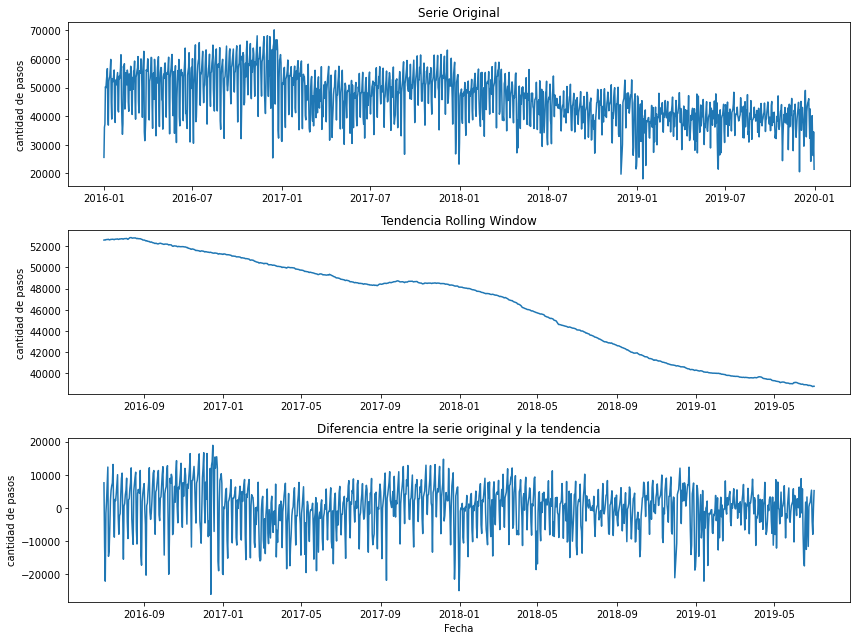

In [24]:
#Grafico la Serie Original, la Tendencia Rolling Window y la diferencia entre ellas
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario_efectivo.index, diario_efectivo.cantidad_pasos)
plt.ylabel('cantidad de pasos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(cantidad_pasos_tendencia)
plt.ylabel('cantidad de pasos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(diario_efectivo.index, diario_efectivo.cantidad_pasos - cantidad_pasos_tendencia)
plt.xlabel('Fecha')
plt.ylabel('cantidad de pasos')

plt.tight_layout()
plt.show()

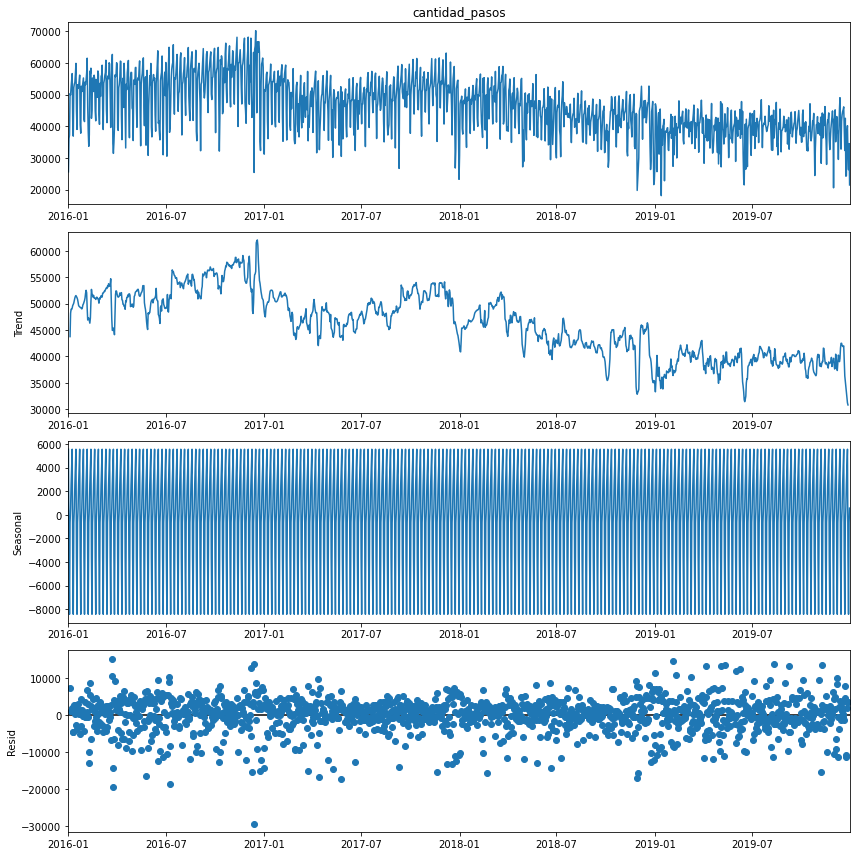

In [25]:
#Utilizo la libreria seasonal_decompose para visualizar la cantidad de pasos, y asi ver deiferentes datos obtenidos con esta herramienta

#Grafico 1: Cantidad de pasos
#Grafico 2: Tendencia
#Grafico 3: Grafico de la estacionalidad
#Grafico 4: Residuos de el valor tomado como referencia (cero) para la nube de datos y la distancia de cada uno de estos hacia ella

import matplotlib

resultados = seasonal_decompose(diario_efectivo.cantidad_pasos, model='additive')
matplotlib.rcParams['figure.figsize'] = [12,12]
resultados.plot()
plt.show()

## MODELOS DE PREDICCION

- Defino primero la función para medir y graficar los errores en el train y el test en cada modelo

In [26]:
# Antes de empezar defino esta funcion para poder observar como funcionan los modelos
def evaluar_regresion(model,x,y, X_train, X_test, y_train, y_test):
   
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
   
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (12,6))

    plt.subplot(1,2,1) #Con el 1,2 definimos la cantidad de gráficos, en este caso 2, y con el 1 del final, definimos la posicion de grafico
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_train,y_train_pred, s =2)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

## One-Step Prediction

Comienzo usando One-step predition

In [27]:
senial = diario_efectivo.cantidad_pasos
senial.head()
senial.shape

(1461,)

In [28]:
#Uso un lookback de 365 para predecir el valor siguiente respecto a un año anterior
look_back = 365 

In [29]:
#Defino la N, X e y
N = senial.shape[0]
X = np.zeros((N - look_back- 1, look_back))  #
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1095, 365) (1095,)


In [30]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [31]:
#Visualizo la X
print(X)

[[25602. 36136. 37225. ... 60291. 61551. 58601.]
 [36136. 37225. 50312. ... 61551. 58601. 31527.]
 [37225. 50312. 49907. ... 58601. 31527. 31183.]
 ...
 [47832. 35446. 21559. ... 24349. 38168. 40182.]
 [35446. 21559. 22599. ... 38168. 40182. 30681.]
 [21559. 22599. 27038. ... 40182. 30681. 26259.]]


In [32]:
#Visualizo la y
print(y)

[31527. 31183. 51568. ... 30681. 26259. 34523.]


In [33]:
# Hacemos el train-test split para luego ingresar a los modelos

N_train = 365*3 - look_back # cantidad de instancias que vamos a usar para entrenar. 2 porque tengo 3 años--si tengo mas años agrego
N_test = 365 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(730, 365) (730,)
(365, 365) (365,)


***1er Modelo: Regresión lineal con regularizacion de Ridge (One-Step Prediction)***

In [34]:
#Defino el modelo a utilizar
diario_ridge = Ridge(alpha=0.05)

In [35]:
# Hago el fiteo del X train e y train
diario_ridge.fit(X_train, y_train)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [36]:
print('Pendiente:', diario_ridge.coef_[:10], '\n' , 'Ordenada:',diario_ridge.intercept_)

Pendiente: [ 0.18088806 -0.0153511   0.00970263 -0.01708561  0.04144928 -0.09210458
  0.04090494  0.02383294 -0.00223592  0.00271179] 
 Ordenada: -5949.208370474495


In [37]:
# Realizo la prediccion con el modelo seleccionado
y_pred_ridge = diario_ridge.predict(X)
y_train_pred_ridge = diario_ridge.predict(X_train)
y_test_pred_ridge = diario_ridge.predict(X_test)

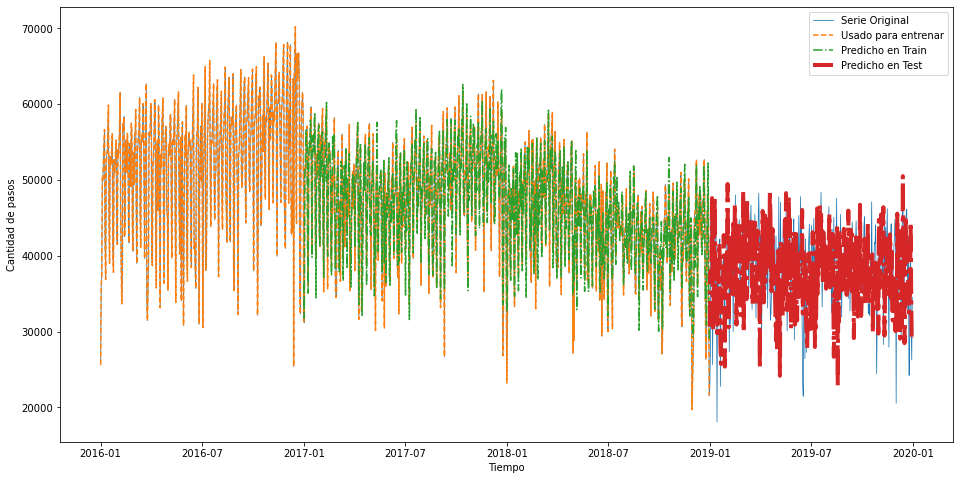

In [38]:
#Grafico los datos del dataset en conjunto con la prediccion del modelo

plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_ridge,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_ridge,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()


- Como podemos visualizar, la prediccion en este caso funciona bien con los datos seleccionados, manteniendo la tendencia y dispersion de los datos que la serie original.

Grafico la importancia de cada atributo

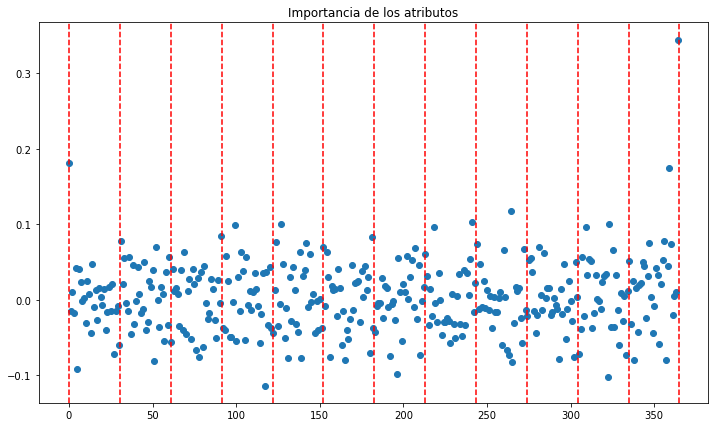

In [39]:
#Grafico de dispersion
plt.figure(figsize = (12,7))
plt.scatter(np.arange(diario_ridge.coef_.size),diario_ridge.coef_) #best_estimator
for X in np.arange(13)*30.42:
     plt.axvline(X, linestyle ='--', color= 'r')
plt.title('Importancia de los atributos')
plt.show()

INTERPRETACION DEL GRAFICO: 
- Los valores de los coeficientes que acompaña a cada valor de la ventana establecida, que es de un año - por eso en el eje x aparece 365. 
- Todos aquellos puntos por encima del ~0.1 son los mas aportan al modelo para la prediccion esperada. 
- Vemos que al principio y al final hay puntos con importancia; o sea que importa para predecir lo que paso hace un año y en los ultimos dias para la prediccion.
- Cada atributo acompaña a cada dato del dia dentro del año; si el valor es alto o muy bajo son importantes en ambos..en el caso de los valores altos negrativos, por ej -0.20 o mas, este atributo es importante pero correlaciona negativamente con la prediccion.
- En sintesis importan mucho los atributos del dia anterior, quiza el valor de 7 dias atras, y el valor de un año atras, por lo que se ve en los puntos mas altos.

Raíz del error cuadrático medio en Train: 3346.5521718631094
Raíz del error cuadrático medio en Test: 6287.154770569385


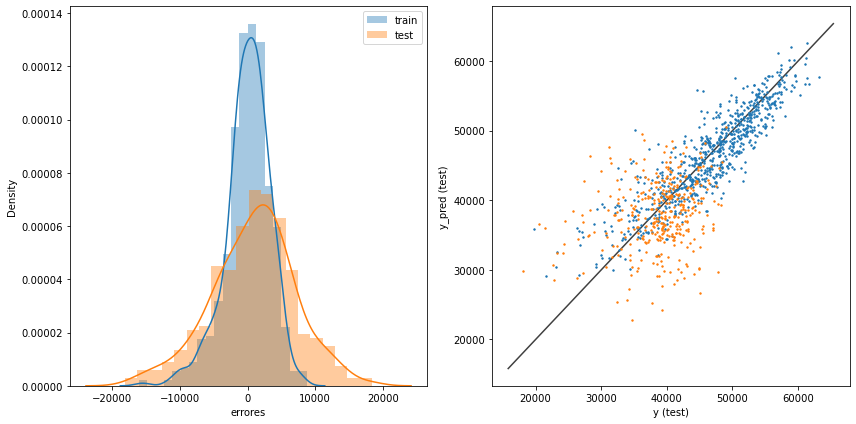

In [40]:
# Evaluo el Modelo y visualizo de los errores en la prediccion
evaluar_regresion(diario_ridge, X, y, X_train, X_test, y_train, y_test)

- La distribucion de los errores no se muestra de la mejor manera o la forma esperada. En el caso del test, se observa que los errores poseen una distribucion no tan en forma de pico, sino mas aplanada por lo que el modelo no es eficaz tanto en los valores menores como en los mayores.
- En el grafico que compara el y_test vs y_test_pred se observa que el modelo no predice bien en general para los valores medias a bajos (principalmente en el test) y mejorando hacia los valores mayores.

***2do Modelo: RANDOM FOREST REGRESSOR (One-Step Prediction)***

In [41]:
#Genero el modelo de Random Forest Regressor
RF_regressor = RandomForestRegressor(random_state=42)
RF_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [42]:
# Realizo la prediccion con el modelo seleccionado
# y_pred_RF = RF_regressor.predict(X)
y_train_pred_RF = RF_regressor.predict(X_train)
y_test_pred_RF = RF_regressor.predict(X_test)

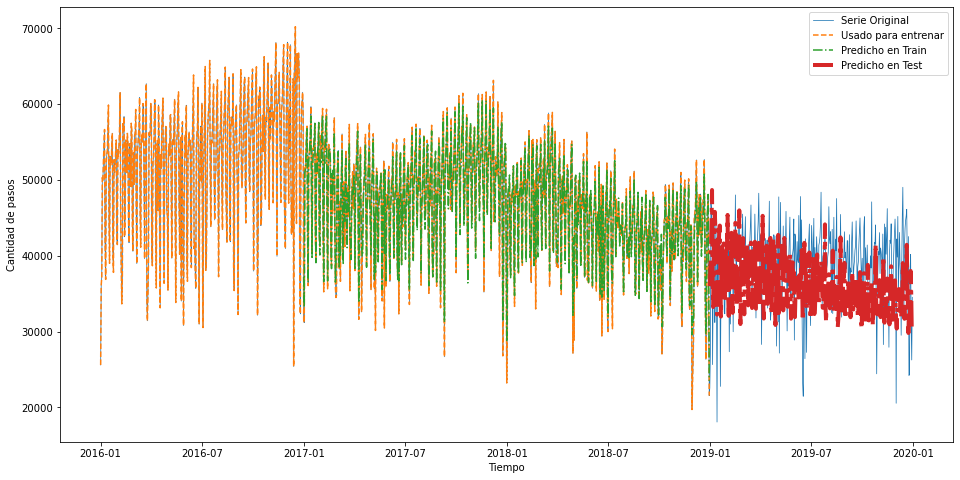

In [43]:
#Grafico los datos del dataset en conjunto con la prediccion del modelo

plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_RF,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_RF,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()


- Como podemos visualizar, la prediccion en este modelo funciona de manera correcta pero no tan precisa con los datos seleccionados, principalmente en comparacion con la serie original de datos, y tambien en comparacion al modelo anterior utilizado de regresion lineal.

Grafico la importancia de cada atributo en el Random Forest

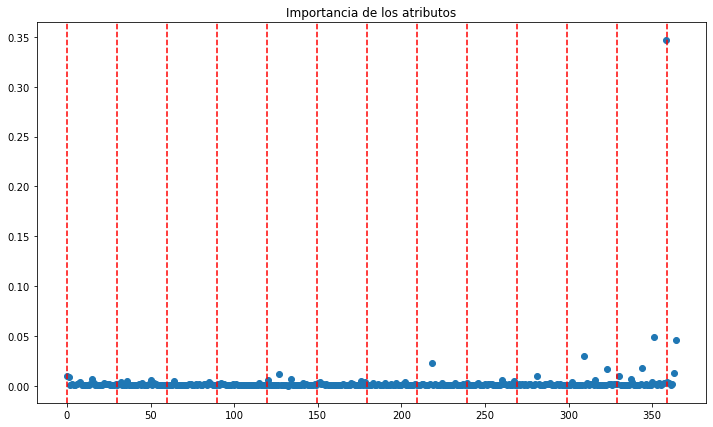

In [44]:
#Grafico de dispersion
plt.figure(figsize = (12,7))
plt.scatter(np.arange(RF_regressor.feature_importances_.size), RF_regressor.feature_importances_)
for X in np.arange(13)*29.9:
     plt.axvline(X, linestyle ='--', color= 'r')
plt.title('Importancia de los atributos')
plt.show()

INTERPRETACION DEL GRAFICO: 
- Observamos que al final hay puntos con importancia, o sea que son importantes para predecir lo que paso en los ultimos dias para la prediccion. En general se trata del dia anterior, y del mismo dia a predecir de una semana hacia atras o dos semanas hacia atras.

Raíz del error cuadrático medio en Train: 1773.7209563540969
Raíz del error cuadrático medio en Test: 5988.317448815715


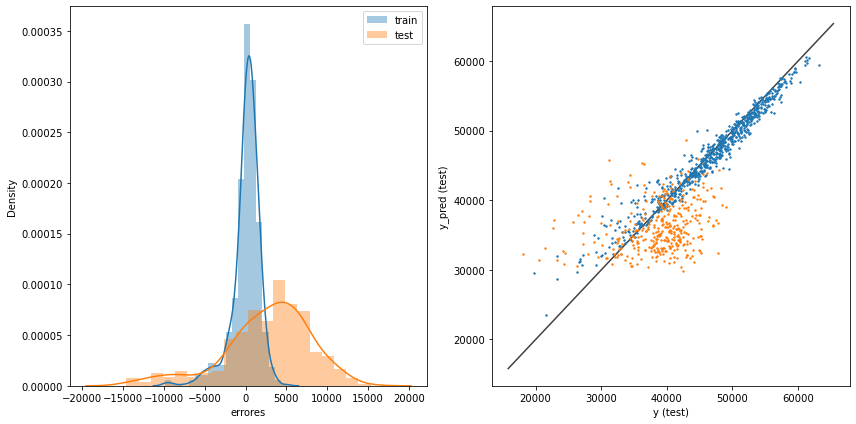

In [45]:
# Evaluo los errores del train y test del Random Forest
evaluar_regresion(RF_regressor, X, y, X_train, X_test, y_train, y_test)

- Puedo ver que la distribucion de los errores no es la esperada, y que existe una diferencia en la prediccion entre el train y el test que me demuestra que existe un overfitting en el modelo.
- Para el train el grafico de los errores muestra un pico definido, y en la comparacion entre la y_test vs y_test_pred se observa mayor error en los valores menores a medios, y una prediccion mucho mas eficaz hacia los valores mayores.
- En el caso del test la distribucion de los errores no es la esperada, mostrando en general mas errores en los mayores valores.

Para mejorar las predicciones realizo una optimizacion de los hiperparametros de los modelos para quedarme con los mejores valores en cada modelo.

***OPTIMIZACION DE LOS HIPERPARAMETROS***

***Optimizacion del 1er Modelo: Regresión lineal (Ridge) con One-Step Prediction***

In [46]:
#Genero un GridSearch para la optimizacion del Regresión linea Ridge
grid_RL_ridge = {'alpha': [10e15,10e14,10e13,10e12,10e11,10e10,10e9,10e8,10e7, 10e6, 10e5, 1000, 100, 10, 5, 1, 0.5, 0.1, 0.01, 0.005, 0.0001],
               'fit_intercept': [True, False]}

In [47]:
# ESTRATEGIA 1: Grid Search
diario_ridge_OPT = GridSearchCV(diario_ridge, param_grid=grid_RL_ridge, cv=5)

In [48]:
diario_ridge_OPT.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=0.05, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e+16, 1000000000000000.0, 100000000000000.0,
                                   10000000000000.0, 1000000000000.0,
                                   100000000000.0, 10000000000.0, 1000000000.0,
                                   100000000.0, 10000000.0, 1000000.0, 1000,
                                   100, 10, 5, 1, 0.5, 0.1, 0.01, 0.005,
                                   0.0001],
                         'fit_intercept': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [49]:
print("Mejores parametros: "+str(diario_ridge_OPT.best_params_)+'\n')
print("Mejor Score: "+str(diario_ridge_OPT.best_score_)+'\n')
print("Mejor estimador: "+str(diario_ridge_OPT.best_estimator_)+'\n')

scores_ridge_OPT = pd.DataFrame(diario_ridge_OPT.cv_results_)
scores_ridge_OPT.head()

Mejores parametros: {'alpha': 100000000000.0, 'fit_intercept': False}

Mejor Score: 0.4313184134125243

Mejor estimador: Ridge(alpha=100000000000.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)



mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.012393  3.875335e-03         0.000999        0.000001       1e+16   
1       0.006996  8.609519e-07         0.000799        0.000400       1e+16   
2       0.009994  1.895470e-03         0.001200        0.000748       1e+15   
3       0.008799  1.943802e-03         0.000799        0.000400       1e+15   
4       0.008991  2.088897e-03         0.000399        0.000489       1e+14   

  param_fit_intercept                                             params  \
0                True            {'alpha': 1e+16, 'fit_intercept': True}   
1               False           {'alpha': 1e+16, 'fit_intercept': False}   
2                True  {'alpha': 1000000000000000.0, 'fit_intercept':...   
3               False  {'alpha': 1000000000000000.0, 'fit_intercept':...   
4                True  {'alpha': 100000000000000.0, 'fit_intercept': ...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0          -0.048590          -0.206771          -0.211121          -0.084393   
1         -38.792166         -53.259553         -43.720670         -43.948857   
2          -0.046779          -0.204895          -0.209634          -0.082775   
3         -18.223872         -26.330371         -22.388593         -20.601721   
4          -0.029153          -0.186674          -0.195172          -0.067083   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0          -0.882021        -0.286579        0.304674               39  
1         -39.763801       -43.897009        5.115347               42  
2          -0.880584        -0.284933        0.304782               38  
3         -17.852823       -21.079476        3.100958               41  
4          -0.866621        -0.268940        0.305835               37

In [87]:
#Defino nuevamente el modelo con los hiperparametros optimizados
diario_ridge_2 = Ridge(alpha= 10000000000, fit_intercept= False)

In [88]:
# Fiteo del X train e y train
diario_ridge_2.fit(X_train, y_train)

Ridge(alpha=10000000000, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Raíz del error cuadrático medio en Train: 3662.4539844293276
Raíz del error cuadrático medio en Test: 5139.898401129664


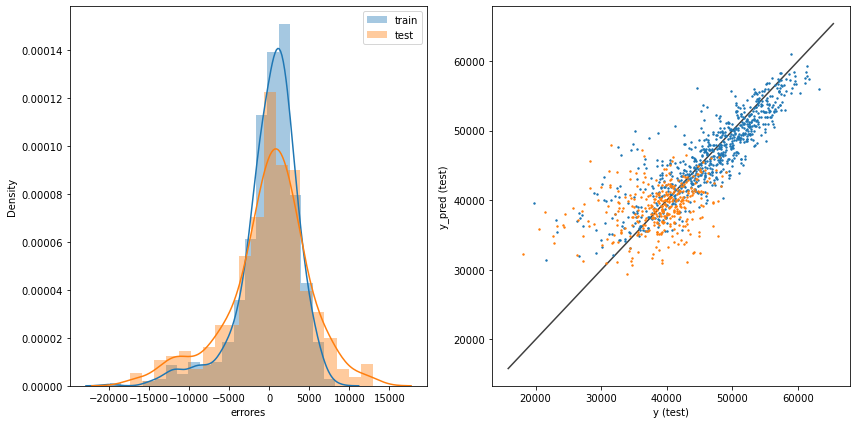

In [89]:
evaluar_regresion(diario_ridge_2, X, y, X_train, X_test, y_train, y_test)

- Puede observarse que la distribucion de los errores se acomodo y es mas cercano a lo que uno podria esperar.

- En el grafico de comparacion entre y_test vs y_test_pred se observa mayor error en los valores menores a medios para el test en comparacion con el train. Este ultimo predice de manera satisfactoria para los valores mayores.

In [53]:
#Busco cual es el mejor valor de alpha para obtener el minimo error posible en el entrenamiento
train = []
test = []
n = []
i = 0

for alpha in [1e20,1e19,1e18,1e17,1e16,1e15,1e14,1e13,1e12,1e11,1e10,1e9, 1e8, 1e7, 1e6, 1e5]:
    diario_ridge_2 = Ridge(alpha= alpha, fit_intercept= False)
    diario_ridge_2.fit(X_train, y_train)
    y_train_pred = diario_ridge_2.predict(X_train)
    y_test_pred = diario_ridge_2.predict(X_test)
    error_train = np.sqrt(mean_squared_error(y_train, y_train_pred)) 
    error_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Error del Train con alpha de {alpha} es de {error_train}')
    print(f'Error del Test con alpha de {alpha} es de {error_test} \n')
    i= i+1
    n.append(alpha)
    train.append(error_train)
    test.append(error_test)

Error del Train con alpha de 1e+20 es de 47060.68935800574
Error del Test con alpha de 1e+20 es de 39123.02843555624 

Error del Train con alpha de 1e+19 es de 47057.99915634044
Error del Test con alpha de 1e+19 es de 39120.80004264374 

Error del Train con alpha de 1e+18 es de 47031.11460417598
Error del Test con alpha de 1e+18 es de 39098.53056139072 

Error del Train con alpha de 1e+17 es de 46764.00427476663
Error del Test con alpha de 1e+17 es de 38877.27122393616 

Error del Train con alpha de 1e+16 es de 44255.8497185643
Error del Test con alpha de 1e+16 es de 36799.48085020103 

Error del Train con alpha de 1000000000000000.0 es de 29059.110580984703
Error del Test con alpha de 1000000000000000.0 es de 24199.15159152237 

Error del Train con alpha de 100000000000000.0 es de 9245.518720565857
Error del Test con alpha de 100000000000000.0 es de 7604.497400044195 

Error del Train con alpha de 10000000000000.0 es de 6408.911969646639
Error del Test con alpha de 10000000000000.0 es

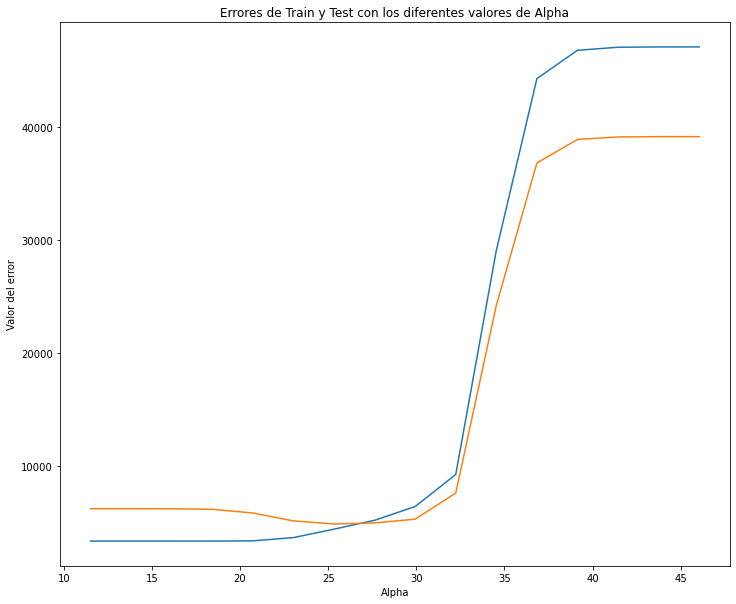

In [54]:
#Grafico los errores obtenidos con los diferentes valores de Alpha
plt.figure(figsize = (12,10))
plt.plot(np.log(n), train, label='train')
plt.plot(np.log(n), test, label='test')
plt.xlabel('Alpha')
plt.ylabel('Valor del error')
plt.title('Errores de Train y Test con los diferentes valores de Alpha')
plt.show()

#Valor de alpha que menos overfittea = 100000000000 o 1e11
# Error del Train con alpha de 100000000000.0 es de 4410.148239691035
# Error del Test con alpha de 100000000000.0 es de 4866.57973305535

#Valor de alpha que menor errror en el train da = 100000000 o 1e8
# Error del Train con alpha de 100000000.0 es de 3354.725967580698
# Error del Test con alpha de 100000000.0 es de 6164.435982317408 

#Valor de alpha que menor errror en el test da = 100000000000 o 1e11
# Error del Train con alpha de 100000000000.0 es de 4410.148239691035
# Error del Test con alpha de 100000000000.0 es de 4866.57973305535 

# logaritmo natural de 100000000000 (1e11) es 25,33

Defino nuevamente el modelo con el valor de alpha seleccionado

In [55]:
#Defino nuevamente el modelo con los hiperparametros optimizados
diario_ridge_2 = Ridge(alpha= 100000000, fit_intercept= False)

In [56]:
# Fiteo del X train e y train
diario_ridge_2.fit(X_train, y_train)

Ridge(alpha=100000000, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Raíz del error cuadrático medio en Train: 3354.725967580698
Raíz del error cuadrático medio en Test: 6164.435982317408


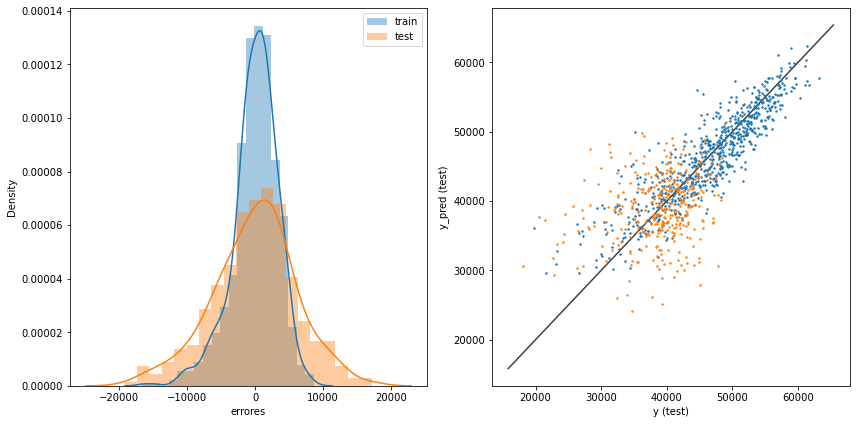

In [57]:
evaluar_regresion(diario_ridge_2, X, y, X_train, X_test, y_train, y_test)

***Regresión lineal con One-Step Prediction***

Sin optimizacion:

- Raíz del error cuadrático medio en Train: 3346.5521718631094
- Raíz del error cuadrático medio en Test: 6287.154770569385

Con optimizacion:

- Raíz del error cuadrático medio en Train: 3354.725967580698
- Raíz del error cuadrático medio en Test: 6164.435982317408


La optimizacion no mejoro significativamente el modelo, mejoro de manera menor la prediccion.

***Optimizacion del 2do Modelo: RANDOM FOREST REGRESSOR (One-Step Prediction)***

In [54]:
#Selecciono los hiperparametros a optimizar con GridSearch para el modelo de RandomForest
param_dist = {'n_estimators': [10,50,70,100],
            'max_depth': [3,5,7,9],
            "min_samples_leaf": [1,2,3,4,5],     
            "min_samples_split": [1,2,3,4,5]}    
param_dist

{'n_estimators': [10, 50, 70, 100],
 'max_depth': [3, 5, 7, 9],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [1, 2, 3, 4, 5]}

In [56]:
# Genero el modelo con el GridSearchCV
model_RF_OPT = GridSearchCV(RF_regressor, param_grid=param_dist, cv=5)

In [57]:
#Entrenamos el nuevo modelo
model_RF_OPT.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [59]:
print("Mejores parametros: "+str(model_RF_OPT.best_params_)+'\n')
print("Mejor Score: "+str(model_RF_OPT.best_score_)+'\n')
print("Mejor estimador: "+str(model_RF_OPT.best_estimator_)+'\n')

scores_RF_OPT = pd.DataFrame(model_RF_OPT.cv_results_)
scores_RF_OPT.head()

Mejores parametros: {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

Mejor Score: 0.48953328108937394

Mejor estimador: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.014392      0.003978         0.000000        0.000000   
1       0.028580      0.003822         0.000000        0.000000   
2       0.041976      0.001276         0.000000        0.000000   
3       0.049971      0.005546         0.000000        0.000000   
4       0.309627      0.011030         0.002195        0.000401   

  param_max_depth param_min_samples_leaf param_min_samples_split  \
0               3                      1                       1   
1               3                      1                       1   
2               3                      1                       1   
3               3                      1                       1   
4               3                      1                       2   

  param_n_estimators                                             params  \
0                 10  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
1                 50  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
2                 70  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
3                100  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
4                 10  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4           0.516892           0.597267           0.409616           0.488675   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0                NaN              NaN             NaN              400  
1                NaN              NaN             NaN              326  
2                NaN              NaN             NaN              324  
3                NaN              NaN             NaN              323  
4           0.180199          0.43853        0.142424              304

In [63]:
#Genero nuevamente el modelo de Random Forest Regressor optimizado
RF_regressor_2 = RandomForestRegressor(random_state=42, n_estimators= 100, min_samples_split= 2, min_samples_leaf= 3, max_depth= 9)
RF_regressor_2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Raíz del error cuadrático medio en Train: 2304.238434218044
Raíz del error cuadrático medio en Test: 5852.96409089356


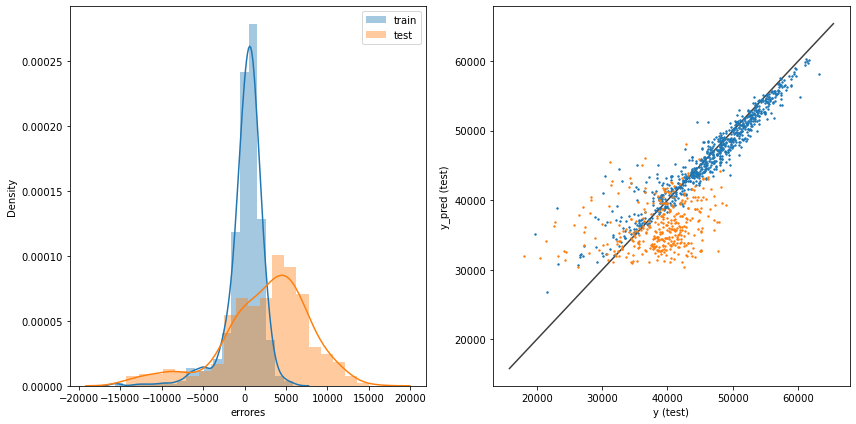

In [64]:
evaluar_regresion(RF_regressor_2, X, y, X_train, X_test, y_train, y_test)

***Optimizacion RandomForest con One-Step Prediction***
    
Sin optimizacion:

- Raíz del error cuadrático medio en Train: 1773.7209563540969
- Raíz del error cuadrático medio en Test: 5988.317448815715

Con optimizacion:

- Raíz del error cuadrático medio en Train: 2304.238434218044
- Raíz del error cuadrático medio en Test: 5852.96409089356

La optimizacion no mejoro significativamente el modelo de RandomForest. Sigue generandose un overfitting entre el train y el test en este modelo. A pesar de esto el modelo sin optimizacion obtiene un RMSE de 1773,7 en el train

## Multi-Step Prediction

Ahora genero los mismos modelos que ya fueron entrenados pero a usando el método recursivo para hacer Multi-Step prediction.


***1er Modelo: Regresion linear con regularizacion de Ridge (Multi-Step Prediction)***

Con el modelo ya optimizado, vamos a usar el método recursivo para hacer Multi-Step prediction.


In [80]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = diario_ridge_2.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

In [81]:
y_train_pred_ridge = diario_ridge_2.predict(X_train)
y_test_pred_ridge = diario_ridge_2.predict(X_test)

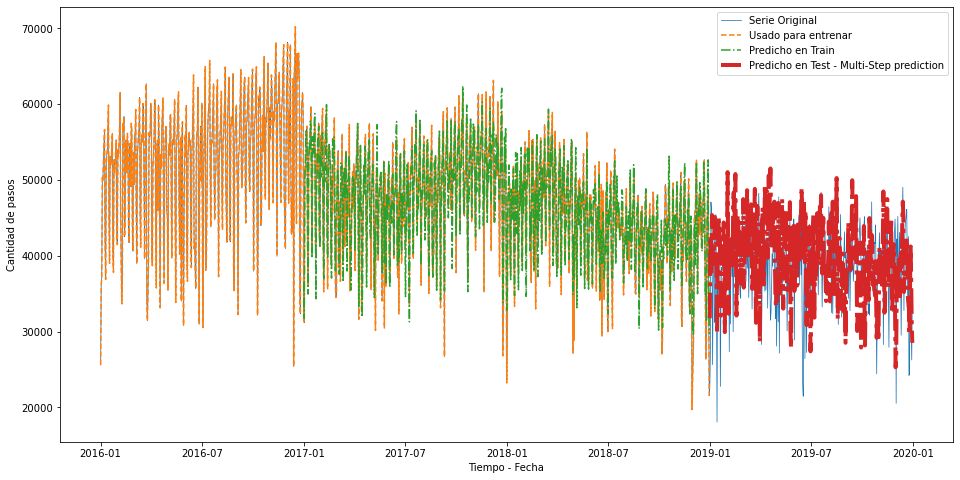

In [82]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_ridge,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test - Multi-Step prediction')
plt.legend()
plt.xlabel('Tiempo - Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()

- Calculamos el error generado por esta metodología

In [68]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Test: 6086.5693169949855


- Realizamos lo mismo pero con el modelo de Random Forest

***2do Modelo: Random Forest Regressor (Multi-Step Prediction)***

In [83]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = RF_regressor_2.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

In [85]:
y_train_pred_rf = RF_regressor_2.predict(X_train)
y_test_pred_rf = RF_regressor_2.predict(X_test)

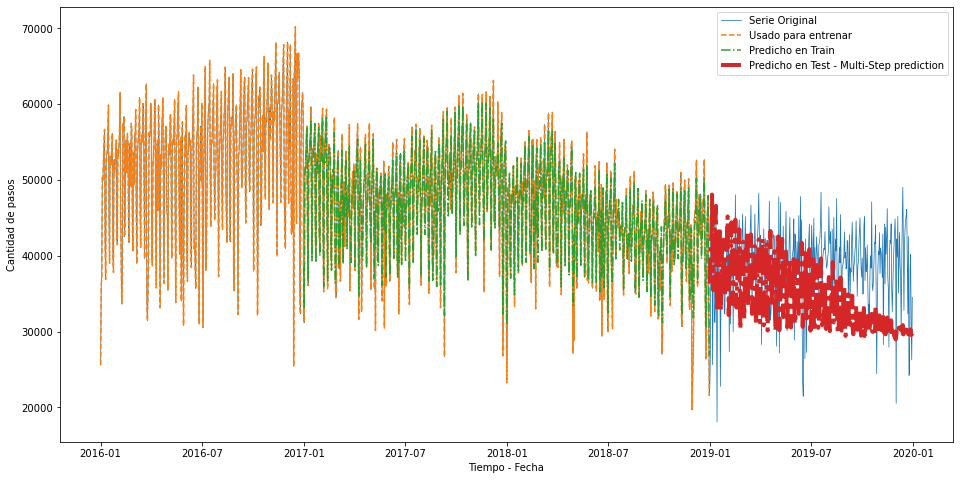

In [86]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_rf,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test - Multi-Step prediction')
plt.legend()
plt.xlabel('Tiempo - Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()

- Calculamos el error generado por esta metodología en el Random Forest

In [71]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Test: 7530.403676540327


In [72]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

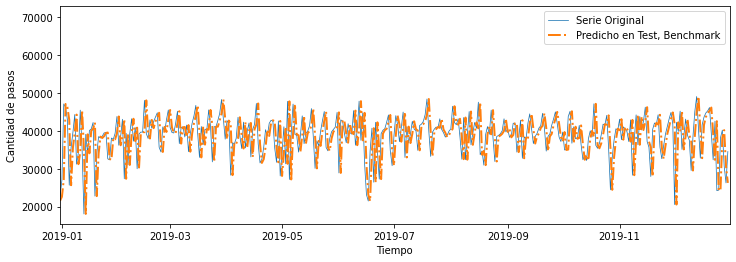

In [73]:
plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

In [74]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print('Error en Test:',np.sqrt(MSE))

Error en Test: 6625.0358281791605


## Elige un modelo benchmark para comparar los resultados de tu modelo

El modelo seleccionado es el modelo lineal con regularizacion de Ridge. El modelo de los otros utilizados es el que mejor funciono de manera general. Se realizo la optimizacion de los hiperparametros y se busco el valor del hiperparametro alpha en el cual se obtenga el menor error del modelo.

***Regresión lineal con One-Step Prediction***

Sin optimizacion:

- Raíz del error cuadrático medio en Train: 3346.5521718631094
- Raíz del error cuadrático medio en Test: 6287.154770569385

Con optimizacion:

- Raíz del error cuadrático medio en Train: 3354.725967580698
- Raíz del error cuadrático medio en Test: 6164.435982317408


La optimizacion no mejoro significativamente el modelo, por lo cual utilizar cualquiera de ambas opciones es viable. En ambos caso el mejor desempeño para predicir la cantidad de pasos obtuvo un valor del error cuadratico medio en el Train de 3354 pasos en la prediccion y de 6164 pasos para el test. En los graficos de la dispersion de los errores y en la prediccion se observo que:

***Modelo con optimizacion:***
- Puede observarse que la distribucion de los errores mejoro respecto al no optimizado y es mas cercano a lo que uno podria esperar de ese tipo de grafico.
- En el grafico de comparacion entre y_test vs y_test_pred se observa mayor error en la prediccion de la cantidad de pasos en los valores menores a medios para el test en comparacion con el train. Este ultimo predice de manera satisfactoria para los valores mayores, acercandose hacia la diagonal que cruza el grafico.
- Los errores vistos pueden deberse a que no tenermos una gran cantidad de datos a traves del tiempo, que podrian ayudar al modelo a predecir mejor la cantidad de pasos teniendo mas datos de entrada y cantidad de pasos diarios.

## Prophet

Profundizo el analisis usando la libreria Prophet

In [75]:
from fbprophet import Prophet

In [76]:
# from prophet import Prophet
m = Prophet()

In [77]:
# Prophet precisa un dataset que tenga dos columnas, una con la fecha y otra con el valor
df_prophet = pd.DataFrame()
df_prophet['ds'] = diario_efectivo.index
df_prophet['y'] = diario_efectivo.cantidad_pasos.values

In [78]:
df_prophet.head()

ds        y
0 2016-01-01  25602.0
1 2016-01-02  36136.0
2 2016-01-03  37225.0
3 2016-01-04  50312.0
4 2016-01-05  49907.0

Ahora fiteamos el Modelo de prophet a nuestra serie temporal

In [109]:
m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


una vez que ya esta fiteado, podemos usarlo para hacer predicciones. Para realizar las predicciones precisamos generarnos un dataframe tambien que contenga las fechas en las cuales queremos predecir. A este dataframe (que consta de solo una columna) lo llamamos 'future'.

In [110]:
# Le pedo una prediccion de 1 año a futuro para comenzar
future = m.make_future_dataframe(periods=365) #realizo una prediccion de un año
future.tail()

ds
1821 2020-12-26
1822 2020-12-27
1823 2020-12-28
1824 2020-12-29
1825 2020-12-30

Una vez que tenemos ese nuevo dataframe, ahora si usamos el metodo predict del modelo.

In [111]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
1821 2020-12-26  27711.513546  21335.397319  34431.543268
1822 2020-12-27  22490.109871  15306.599358  29549.813569
1823 2020-12-28  29851.850484  23100.830527  36625.726225
1824 2020-12-29  30662.250004  23223.744795  37161.365311
1825 2020-12-30  32378.481214  25316.125483  39525.227699

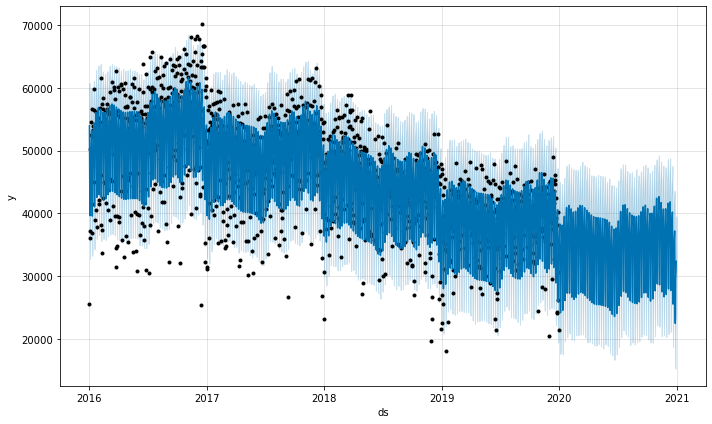

In [112]:
fig1 = m.plot(forecast)

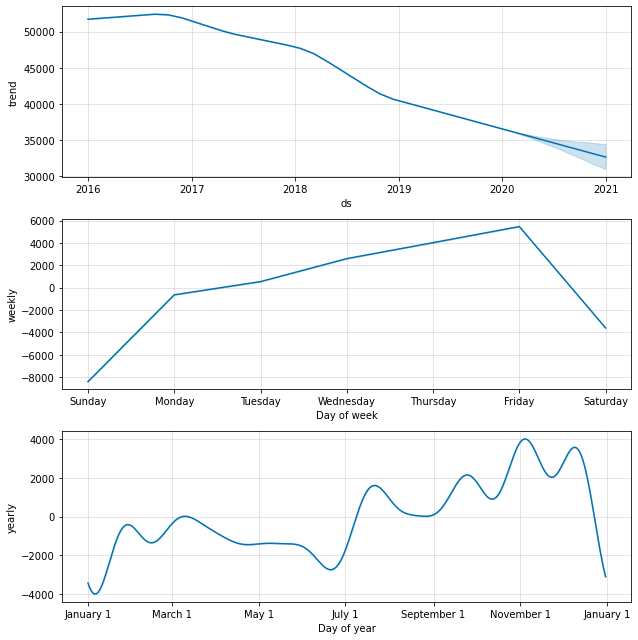

In [113]:
fig2 = m.plot_components(forecast)

#### Tendencia diaria con Prophet
En el ejmplo anterior solo vemos la tendencia anual porque solo usamos solo la data semanal (promediamos todos los dias de la semana). 

A continuación probamos como quedaría si usamos la data diaria. Para esto volvemos  cargar a preprosesar el dataset.

In [114]:
m_diario = Prophet()

In [115]:
# Generamos nuevamente el Dataframe para el prophet. Esta vez con los valores diarios.
df_prophet_diario = pd.DataFrame()
df_prophet_diario['ds'] = diario_efectivo.index
df_prophet_diario['y'] = diario_efectivo.cantidad_pasos.values

In [116]:
# Fiteamos el modelo
m_diario.fit(df_prophet_diario)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [117]:
# Generamos Nuevamente un dataframe a futuro
future_diario = m_diario.make_future_dataframe(periods=365*5) #realizo una prediccion a 5 años
future_diario.tail()

ds
3281 2024-12-25
3282 2024-12-26
3283 2024-12-27
3284 2024-12-28
3285 2024-12-29

In [118]:
# Predecimos sobre el dataset a futuro
forecast_diario = m_diario.predict(future_diario)

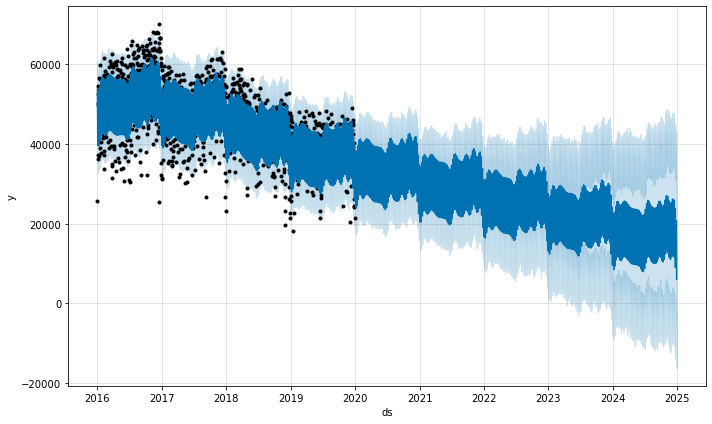

In [119]:
fig3 = m_diario.plot(forecast_diario)

Ahoras graficamos las componentes. Notemos que tenemos una tendencia, una estacionalidad mensual y una estacionalidad semanal.

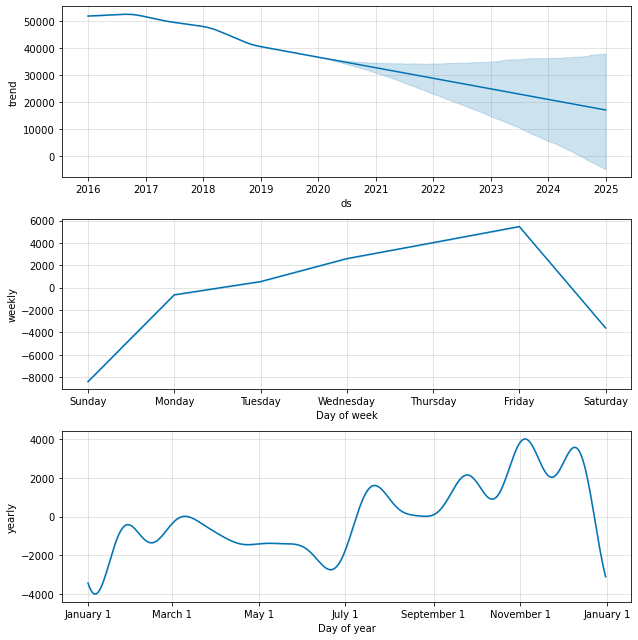

In [120]:
fig4 = m_diario.plot_components(forecast_diario)

## CIERRE

Para cerrar con este proyecto...

Como conclusion y cierre podemos decir que...